In [ ]:
!pip install pyspark

  Using cached pyspark-3.3.1-py2.py3-none-any.whl
  Using cached py4j-0.10.9.5-py2.py3-none-any.whl (199 kB)


In [ ]:
from pyspark import SparkContext
sc=SparkContext(master ='local[2]')
import findspark
findspark.init()
import pyspark
sc

<SparkContext master=local[2] appName=pyspark-shell>

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName("Datacamp Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

In [ ]:
df = spark.read.csv('C:/Users/btt38/Downloads/Online Retail.csv',header=True,escape="\"")

In [ ]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate     |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/01/2010 08:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/01/2010 08:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/01/2010 08:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/01/2010 08:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/01/2010 08:26|3.39     |17850     |United Kingdom|
+---------+---------+-------------------

In [ ]:
df.count()  # Answer: 2,500

541909

In [ ]:
df.select('CustomerID').distinct().count() # Answer: 95

4373

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).show()

+------------------+-------------+
|           Country|country_count|
+------------------+-------------+
|            Sweden|            8|
|         Singapore|            1|
|           Germany|           95|
|               RSA|            1|
|            France|           87|
|            Greece|            4|
|European Community|            1|
|           Belgium|           25|
|           Finland|           12|
|             Malta|            2|
|       Unspecified|            4|
|             Italy|           15|
|              EIRE|            3|
|         Lithuania|            1|
|            Norway|           10|
|             Spain|           31|
|           Denmark|            9|
|         Hong Kong|            0|
|            Israel|            4|
|           Iceland|            1|
+------------------+-------------+
only showing top 20 rows



In [ ]:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|        Denmark|            9|
|         Cyprus|            8|
|          Japan|            8|
|         Sweden|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [ ]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'MM/dd/yyyy HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



In [ ]:
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



In [ ]:
df = df.withColumn("from_date", lit("12/1/10 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("from_date").cast("long") - col('date').cast("long"))

In [ ]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

In [ ]:
df2.show(5,0)

+--------+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+-------------------+-------------------+
|recency |InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate     |UnitPrice|CustomerID|Country       |date               |from_date          |
+--------+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+-------------------+-------------------+
|34992000|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/01/2010 08:26|2.55     |17850     |United Kingdom|2010-12-01 08:26:00|2012-01-10 08:26:00|
|34992000|536365   |71053    |WHITE METAL LANTERN                |6       |12/01/2010 08:26|3.39     |17850     |United Kingdom|2010-12-01 08:26:00|2012-01-10 08:26:00|
|34992000|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/01/2010 08:26|2.75     |17850     |United Kingdom|2010-12-01 08:26:00|2012-01

In [ ]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



In [ ]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

In [ ]:
df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|16250     |14       |
|15574     |121      |
|15555     |32       |
|15271     |24       |
|17714     |10       |
+----------+---------+
only showing top 5 rows



In [ ]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [ ]:
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



In [ ]:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

In [ ]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

In [ ]:
finaldf = m_val.join(df3,on='CustomerID',how='inner')

In [ ]:
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()

In [ ]:
finaldf.show(5,0)

+--------+---------+--------------+----------+
|recency |frequency|monetary_value|CustomerID|
+--------+---------+--------------+----------+
|34986420|14       |226.14        |16250     |
|34879200|121      |375.65        |15574     |
|34623660|32       |198.43        |15555     |
|34281540|24       |111.75        |15271     |
|30405240|10       |153.0         |17714     |
+--------+---------+--------------+----------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=['recency','frequency','monetary_value'], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [ ]:
data_scale_output.select('standardized').show(2,truncate=False)

+-----------------------------------------------------------+
|standardized                                               |
+-----------------------------------------------------------+
|[3.3952770721048218,0.4795690524992825,0.16906206335260998]|
|[3.3848718460865244,4.144846810886656,0.28083560669677166] |
+-----------------------------------------------------------+
only showing top 2 rows



In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

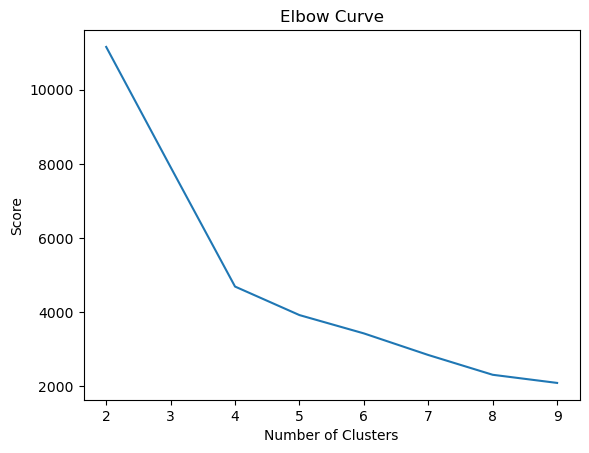

In [ ]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
KMeans_algo=KMeans(featuresCol='standardized', k=6)
KMeans_fit=KMeans_algo.fit(data_scale_output)

In [ ]:
preds=KMeans_fit.transform(data_scale_output)
preds.show(5,0)

+--------+---------+--------------+----------+------------------------+------------------------------------------------------------+----------+
|recency |frequency|monetary_value|CustomerID|features                |standardized                                                |prediction|
+--------+---------+--------------+----------+------------------------+------------------------------------------------------------+----------+
|34986420|14       |226.14        |16250     |[3.498642E7,14.0,226.14]|[3.3952770721048218,0.4795690524992825,0.16906206335260998] |5         |
|34879200|121      |375.65        |15574     |[3.48792E7,121.0,375.65]|[3.3848718460865244,4.144846810886656,0.28083560669677166]  |3         |
|34623660|32       |198.43        |15555     |[3.462366E7,32.0,198.43]|[3.3600728211218187,1.0961578342840743,0.14834609193888035] |5         |
|34281540|24       |111.75        |15271     |[3.428154E7,24.0,111.75]|[3.326871590704174,0.8221183757130557,0.08354420084750228]  |5   

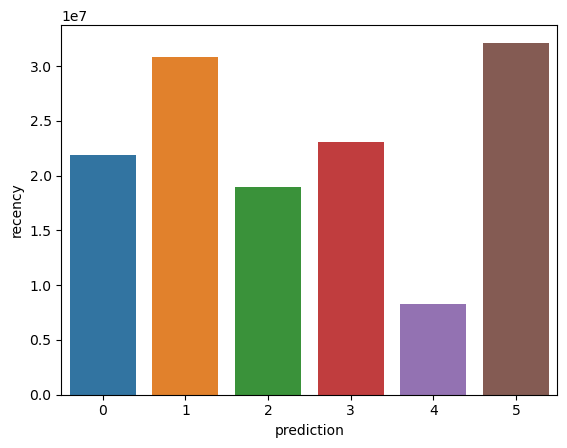

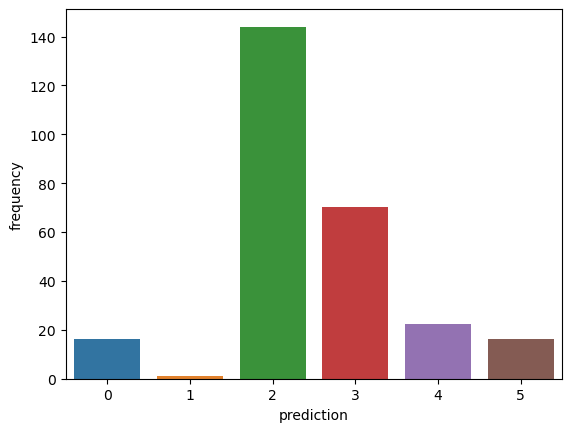

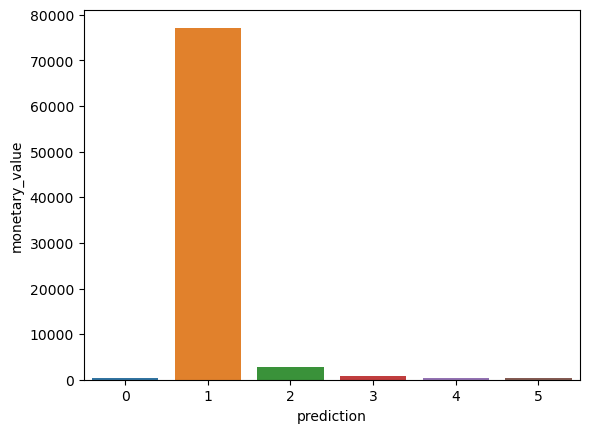

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()